<a href="https://colab.research.google.com/github/AraiKensuke/GCoh/blob/Include_dpss_bw_in_preprocessver/simulations/simulated_multichannel_EEG_Gcoh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Install necessary packages.

In [2]:
#########  clone and install necessary packages from github repositories

import sys
import importlib

if importlib.util.find_spec("GCoh") is None:
  !git clone https://github.com/AraiKensuke/GCoh.git

if importlib.util.find_spec("mne") is None:
  !pip install mne

sys.path.insert(1, "/content/GCoh")    #  add these to searchpath for python modules

Cloning into 'GCoh'...
remote: Enumerating objects: 250, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 250 (delta 3), reused 0 (delta 0), pack-reused 239
Receiving objects: 100% (250/250), 4.10 MiB | 17.15 MiB/s, done.
Resolving deltas: 100% (148/148), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 4.7 MB/s 


# 2)  Create simulated EEG data with multiple coherent channels.  
By coherent, we mean here phase locked in some frequency range.  The EEG data we create here is a noisy oscillation in 20Hz range in each channel.  At certain times, several channels will form a temporary group that will be coherent (but can have a fixed
phase difference between them) for a few seconds.  


In [44]:
#####  Generate simulated EEG data.

import numpy as _N
import os
import mne

import GCoh.datconfig as datconf
import GCoh.simulations.sim_utils as _su
import warnings

warnings.filterwarnings("ignore")

lblsz=14
tksz=12
def showEEG(t0, t1, bpfilter=None):
  if bpfilter is not None:
    l_freq=bpfilter[0]
    h_freq=bpfilter[1]
    showEEG = mne.filter.filter_data(EEG, Fs, l_freq, h_freq, verbose=False)
  else:
    showEEG = EEG
  fig = _plt.figure(figsize=(13, 13))
  _plt.suptitle("t0: %(0)ds    t1: %(1)ds" % {"0" : t0, "1" : t1}, fontsize=(lblsz+2))
  maxY  = _N.max(showEEG[:, t0*Fs:t1*Fs])
  minY  = _N.min(showEEG[:, t0*Fs:t1*Fs])
  A     = maxY - minY
  for ich  in range(nChs):
      fig.add_subplot(nChs, 1, ich+1)
      _plt.plot(showEEG[ich, t0*Fs:t1*Fs], color="black")
      if ich == nChs-1:
        _plt.xticks(_N.linspace(0, (t1-t0)*Fs, t1-t0, endpoint=False), _N.arange(t0, t1), fontsize=tksz)
        _plt.xlabel("time (s)", fontsize=lblsz)
      else:
        _plt.xticks(_N.linspace(0, (t1-t0)*Fs, t1-t0, endpoint=False), [""]*(t1-t0))
      _plt.xlim(0, (t1-t0)*Fs)
      _plt.ylim(minY-0.05*A, maxY+0.05*A) 
      _plt.yticks([])
      _plt.ylabel("ch %d" % (ich+1), fontsize=lblsz)

###  Define groups of channels that will be coherent
grpA = _N.array([1, 2, 5])
grpB = _N.array([3, 4, 8])
grpC = _N.array([7, 8, 9])

###  These groups can have some phase difference (in samples) between
###  them.
grpA_phase_diff = _N.array([0, -2, 5])
grpB_phase_diff = _N.array([0, 10, -3])
grpC_phase_diff = _N.array([0, 1, 1])

###  Simulation parameters
Fs   = 200     #  sampling frequency of data
dt   = 1/Fs
nChs = 10      #  # of EEG channels
N    = 20000   # how many temporal timepoints to generate
f    = 10      #  oscillation frequency.  We assume all channels 
               #  are (noisly) oscillating at this frequency.

###  
rhythms = _N.zeros((nChs, N))
pknzs   = _N.zeros((nChs, N))
tau     = 0.02    #  timescale of independent AR1 signal in all channels
tau_com = 0.14    #  timescale of common AR1 signal in all channels

######  Common signal
common_to_all_chs = _su.AR1(tau_com, N, dt) * 0.8

######  we generate simulated EEG by generating nChs of independent oscillatory
######  signals (AR2 signals) and add them to independent background activity
######  AR1.

for nc in range(nChs):
    rhythms[nc] = _su.AR2(f, 0.95, N, dt)
    pknzs[nc] = _su.AR1(tau, N, dt)*2 + common_to_all_chs
EEG     = _N.array(pknzs)

######  This alters the 'EEG' vector by replacing the channels defined in groups
######  by the data in 1 of the channels in the group, and adding a bit of noise
######  to each of the channels to simulate "coherence"  Then we add a bit of 
######  phase shift to each channel in the group.

_su.mix(dt, EEG, rhythms, grpB, grpB_phase_diff, 18, 30)
_su.mix(dt, EEG, rhythms, grpA, grpA_phase_diff, 33, 44)
_su.mix(dt, EEG, rhythms, grpB, grpB_phase_diff, 44, 60)
_su.mix(dt, EEG, rhythms, grpC, grpC_phase_diff, 65, 90)




#3) Look at the waveform near where a pattern turns on**

Take a look at the raw waveforms.  Filter to frequency band where coherence takes place.  It is not immediately clear that there are coherence oscillations
between channels.

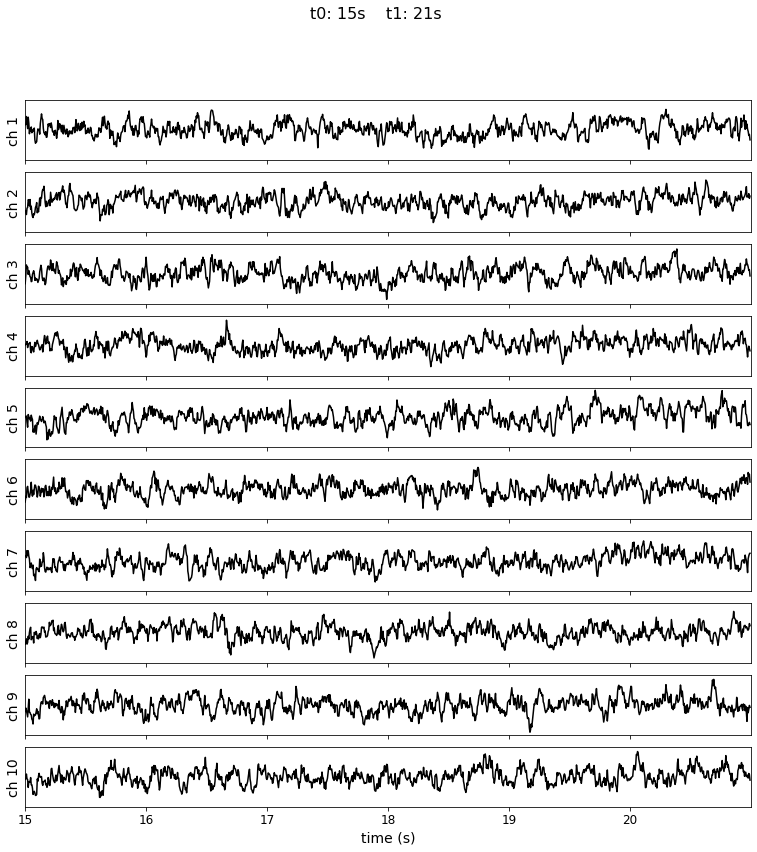

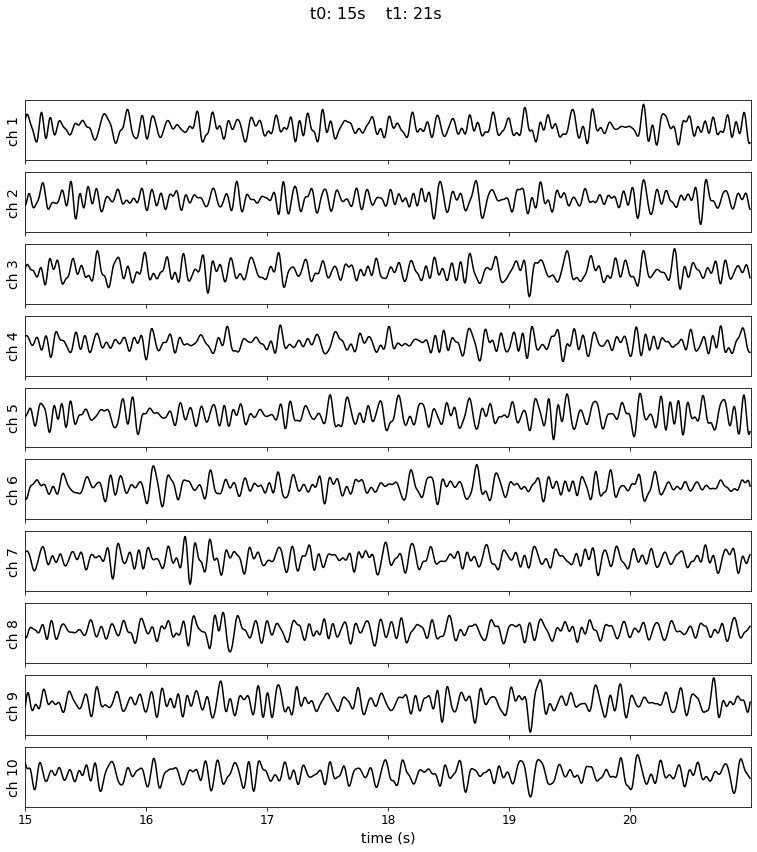

In [46]:
import matplotlib.pyplot as _plt

showEEG(15, 21)
showEEG(15, 21, bpfilter=[5, 15])

# 4)  Calculate the GCoh and eigenvectors.  

Here the only thing to that might need to be changed is win and slideby.  Window over which GCoh is calculated, and
how much the window is slid (allows overlapping).  

**Warning, lots of ominmous looking warnings will be printed.  Ignore these**

In [47]:
import numpy as _N
import scipy.signal as _ssig
import mne.time_frequency as mtf
import mne
import pickle
import sys

import GCoh.chronux_py.chronux_funcs as _chrf
import preprocess_ver

import GCoh.datconfig as datconf
import GCoh.windowed_gcoh as _w_gcoh

dataset =    datconf._SIM    ####  Which data set to use?  
Fs      = 200

#####  These will call up preset values the win, slideby.  Don't have to use these, and
#####  can come up with own.
artrmv_ver = 1
gcoh_ver    = 5

#win, slideby      = preprocess_ver.get_win_slideby(gcoh_ver)
win, slideby       = 768, 64
ch_names = ["eeg1", "eeg2", "eeg3", "eeg4", "eeg5", "eeg6", "eeg7", "eeg8", "eeg9", "eeg10"]
rm_chs = []
ch_w_CM, rm_chs, list_ch_names, ch_types = datconf.getConfig(dataset, sim_nchs=10)

X_cm    = EEG.T

ch_picks = _N.setdiff1d(ch_w_CM, _N.array(rm_chs))
arr_ch_picks = _N.array(ch_picks)

info = mne.create_info(ch_names=(_N.array(ch_names)[ch_picks]).tolist(), ch_types=(_N.array(ch_types)[ch_picks]).tolist(), sfreq=Fs)

datconf.set_montage(dataset, info)

#####  Calculate GCoh and eigenvectors
dpss_bw=7
f, findx, Ctot, Cvec = _w_gcoh.windowed_gcoh(Fs, win, slideby, X_cm, ch_w_CM, ch_picks, info, dpss_bw=dpss_bw)


    Using multitaper spectrum estimation with 25 DPSS windows
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
win 0 of 301
win 20 of 301
win 40 of 301
win 60 of 301
win 80 of 301
win 100 of 301
win 120 of 301
win 140 of 301
win 160 of 301
win 180 of 301
win 200 of 301
win 220 of 301
win 240 of 301
win 260 of 301
win 280 of 301
win 300 of 301


# 5) Cluster and visualize Eigenvalues

doing GMM
@!!!!! 
(array([3, 3]), array([ 1, 14]))
manual_clustering   False


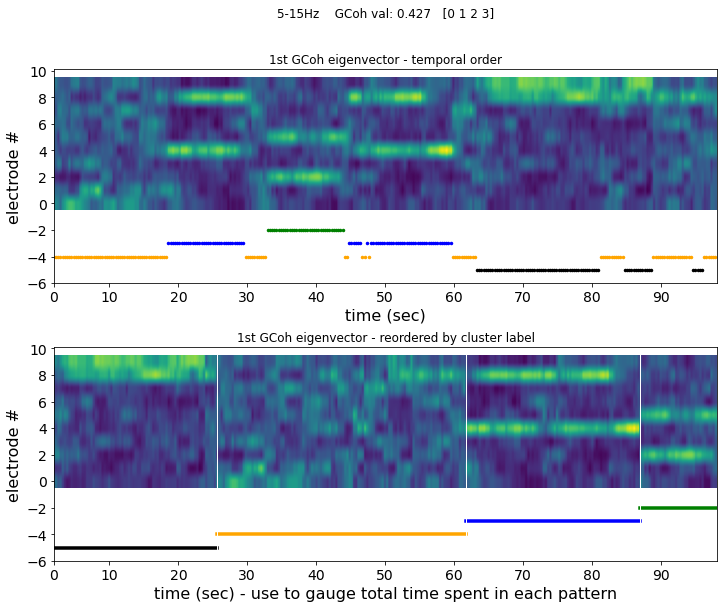

In [48]:
import scipy.stats as _ss
import matplotlib.pyplot as _plt
from sklearn import mixture
from GCoh.eeg_util import unique_in_order_of_appearance, increasing_labels_mapping, rmpd_lab_trnsfrm, find_or_retrieve_GMM_labels, shift_correlated_shuffle, mtfftc
import GCoh.preprocess_ver as _ppv

arr_ch_names = _N.array(list_ch_names)

ev_n   = 0


_WIDE = 0
_MED  = 1
_FINE = 2
_FINE1 = 3   #


_FINE = 1

manual_cluster=False

hlfOverlap = int((win/slideby)*0.5)

strt       = 0  #  if start at middle of experiment
A_gcoh     = Cvec[strt:]
fs       = f[findx]

imag_evs  = Cvec[strt:, :, ev_n]

L_gcoh  = A_gcoh.shape[0]
nChs    = imag_evs.shape[2]
real_evs  = _N.empty((L_gcoh, fs.shape[0], nChs))



chs = _N.arange(nChs)
ch_names = arr_ch_names[chs].tolist()

for ti in range(L_gcoh):
    real_evs[ti] = _N.abs(imag_evs[ti])

mn = _N.mean(real_evs, axis=0)
sd = _N.std(real_evs, axis=0)


frngs = [5, 15]    ##  frequency ranges (low and high) to look at for clustering.  

ignore_stored = True
pcs     = _N.empty(len(frngs))
####  set range of clusters to look for
minK    =1
maxK    =9

try_Ks  = _N.arange(minK, maxK+1)
#TRs      = _N.array([1, 1, 3, 5, 10, 15, 20, 25, 25])  # more tries for higher K
TRs      = _N.array([1, 15, 20, 25, 25, 30, 40, 50, 60, 60, 60, 60, 60, 60, 80, 80, 80, 80])  # more tries for higher K

bics = _N.ones(((maxK-minK), _N.max(TRs)))*1000000
labs = _N.empty((maxK-minK, _N.max(TRs), real_evs.shape[0]), dtype=_N.int)

nState_start = 0

fL = frngs[0]
fH = frngs[1]

irngs = _N.where((fs > fL) & (fs < fH))[0]
iL    = irngs[0]
iH    = irngs[-1]    


gcoh_ver=2
#Apr242020_16_53_03_gcoh_256_64
nStates, rmpd_lab = find_or_retrieve_GMM_labels(None, None, None, real_evs, iL, iH, fL, fH, artrmv_ver, gcoh_ver, which=0, try_K=try_Ks, TRs=TRs, ignore_stored=ignore_stored, manual_cluster=manual_cluster, do_pca=False, min_var_expld=0.95, dontsave=True)
ps = _N.arange(nStates)
ps += nState_start
nState_start += nStates

#nStates, rmpd_lab = find_or_retrieve_GMM_labels(rpsm[dat], "%(dat)s_gcoh_%(w)d_%(s)d" % {"dat" : dat, "w" : bin, "s" : slide}, real_evs, iL, iH, fL, fH, which=0, try_K=try_Ks, TRs=TRs, log_transform=False)
"""
###############
for K in range(minK, maxK):
    for tr in range(TRs[K]):
        gmm = mixture.GaussianMixture(n_components=K, covariance_type="full")

        gmm.fit(_N.sum(real_evs[:, iL:iH], axis=1))
        bics[K-minK, tr] = gmm.bic(_N.sum(real_evs[:, iL:iH], axis=1))
        labs[K-minK, tr] = gmm.predict(_N.sum(real_evs[:, iL:iH], axis=1))

coords = _N.where(bics == _N.min(bics))
print("min bic %.4e" % _N.min(bics))
bestLab = labs[coords[0][0], coords[1][0]]   #  indices in 2-D array
rmpd_lab = increasing_labels_mapping(bestLab)

nStates =  list(range(minK, maxK))[coords[0][0]]
"""
out_u = _N.mean(real_evs[:, iL:iH], axis=1)
out = _N.empty((L_gcoh, nChs))
iS  = 0
for ns in range(nStates):
    ls = _N.where(rmpd_lab == ns)[0]
    out[iS:iS+len(ls)] = _N.mean(real_evs[ls, iL:iH], axis=1)
    iS += len(ls)

iS = 0
clrs  = ["black", "orange", "blue", "green", "red", "lightblue", "grey", "pink", "yellow", "brown", "cyan", "purple", "black", "orange", "blue", "green", "red", "black", "orange", "blue", "green", "red", "lightblue", "grey", "pink", "yellow", "brown", "cyan", "purple", "black", "orange", "blue", "green", "red"]
W   = L_gcoh
H   = nChs
disp_wh_ratio = 5
aspect = (W/H)/disp_wh_ratio
unit = 2.5
fig = _plt.figure(figsize=(disp_wh_ratio*unit + 1, 3*unit+unit/2))
#   time of middle of window in which GCoh calculated
gcoh_ts = _N.linspace(0, (slideby/Fs)*L_gcoh, L_gcoh, endpoint=False) + (win/2)/Fs
gcoh_bins=_N.arange(L_gcoh)
T_max   = gcoh_ts[-1]
time_at_ticks = _N.array(_N.linspace(0, _N.floor(T_max/10)*10, 10), dtype=_N.int)
bin_at_ticks = _N.interp(time_at_ticks, gcoh_ts, gcoh_bins)

_plt.subplot2grid((2, 1), (0, 0))        
_plt.title("1st GCoh eigenvector - temporal order")
#fig.add_subplot(nStates+2, 1, 1)  
_plt.imshow(out_u.T, aspect=aspect)
_plt.ylim(-(nStates+2), nChs+0.1)
for ns in range(nStates):
    nsx = _N.where(rmpd_lab == ns)[0]
    _plt.scatter(nsx, _N.ones(len(nsx))*ns - nStates - 1, color=clrs[ns], lw=1.5, s=4)
_plt.xlim(0, L_gcoh)
_plt.xlabel("(sample #) - not in experimental temporal order", fontsize=17)
_plt.ylabel("electrode #", fontsize=16)
_plt.xlabel("time (sec)", fontsize=16)
_plt.xticks(bin_at_ticks, time_at_ticks, fontsize=14)
_plt.yticks(fontsize=14)

_plt.subplot2grid((2, 1), (1, 0))        
_plt.title("1st GCoh eigenvector - reordered by cluster label")
#fig.add_subplot(nStates+2, 1, 1)    
_plt.imshow(out.T, aspect=aspect)
_plt.ylim(-(nStates+2), nChs+0.1)
for ns in range(nStates):
    ls = _N.where(rmpd_lab == ns)[0]
    liS = iS
    iS += len(ls)
    _plt.plot([liS, iS], [ns-nStates-1, ns-nStates-1], color=clrs[ns], lw=3.5)
    if ns < nStates-1:
        _plt.axvline(x=iS, color="white", lw=1)
_plt.xlim(0, L_gcoh)
_plt.suptitle("%(1)d-%(2)dHz    GCoh val: %(gcoh).3f   %(sts)s" % {"1" : fL, "2" : fH, "gcoh" : _N.mean(Ctot[:, irngs]), "sts" : str(ps)})
_plt.xlabel("(sample #) - not in experimental temporal order", fontsize=17)
_plt.ylabel("electrode #", fontsize=16)
_plt.xlabel("time (sec) - use to gauge total time spent in each pattern", fontsize=16)
_plt.xticks(bin_at_ticks, time_at_ticks, fontsize=14)
_plt.yticks(fontsize=14)

iS = 0
for ns in range(nStates):
    ls = _N.where(rmpd_lab == ns)[0]
    iS += len(ls)
    if ns < nStates-1:
        _plt.axvline(x=iS, color="white", lw=1)
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, hspace=0.3)


**Ground truth patterns**

18-30:  pattern 1    (1, 2, 5)

33-44:  pattern 2    (3, 4, 8)

44-60:  pattern 1    (1, 2, 5)

65-90:  pattern 3    (7, 8, 9)

pattern 0 at all other times